In [1]:
from InterOptimus.itworker import InterfaceWorker
from pymatgen.core.structure import Structure
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

# Input film & substrate CONVENTIONAL structure

In [2]:
with MPRester('fFtrdShVJH4jwWHiId8v4cyGzV2oYnoG') as mpr:
        docs = mpr.materials.summary.search(
        material_ids = ["mp-1153", "mp-362"],
        fields=["material_id", "structure", "nelements"])
        for doc in docs:
            material_id = doc.material_id
            structure = doc.structure
    
            # 使用 SpacegroupAnalyzer 获取常规结构
            analyzer = SpacegroupAnalyzer(structure)
            doc.structure = analyzer.get_conventional_standard_structure()
for i in docs:
    if i.material_id == "mp-1153":
        film_conv = i.structure
    else:
        substrate_conv = i.structure
iw = InterfaceWorker(film_conv, substrate_conv)

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

# Define InterfaceWorker

In [3]:
iw = InterfaceWorker(film_conv, substrate_conv)

# lattice matching

In [4]:
iw.lattice_matching(max_area = 47, max_length_tol = 0.03, max_angle_tol = 0.03,
                    film_max_miller = 1, substrate_max_miller = 1, film_millers = None, substrate_millers = None)
#Note max millers are in primitive cell, should be different from the indices in the polar projection below which are in conventional cell
#If you specify miller indices yourself, just ignore film_max_miller and substrate_max_miller

24


checking matching identity:   0%|          | 0/24 [00:00<?, ?it/s]

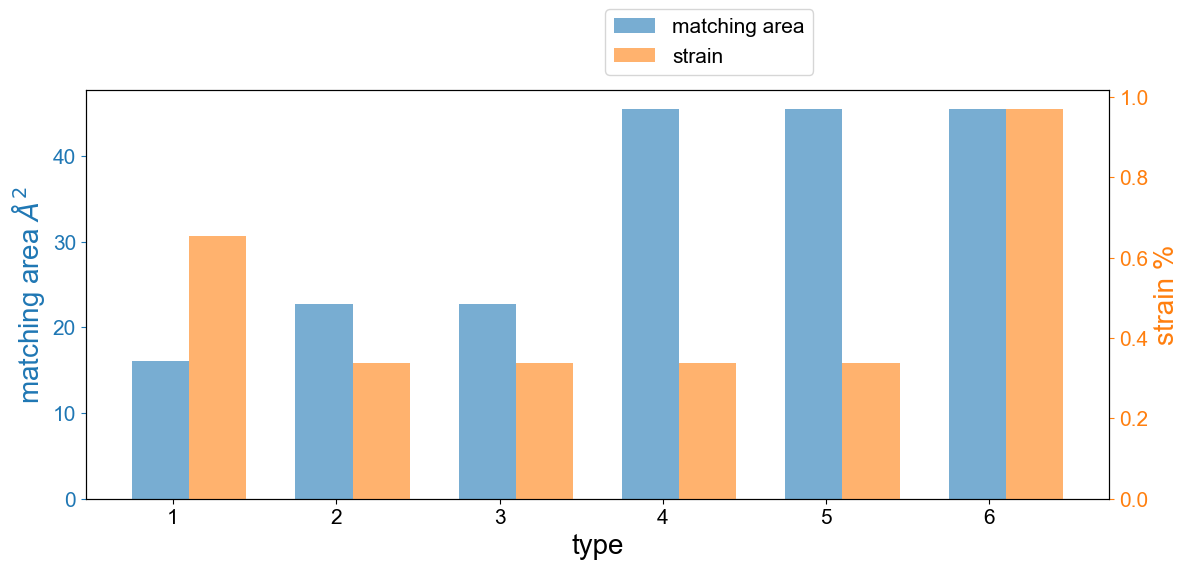

In [5]:
#Visualize matching information
iw.ems.plot_unique_matches()

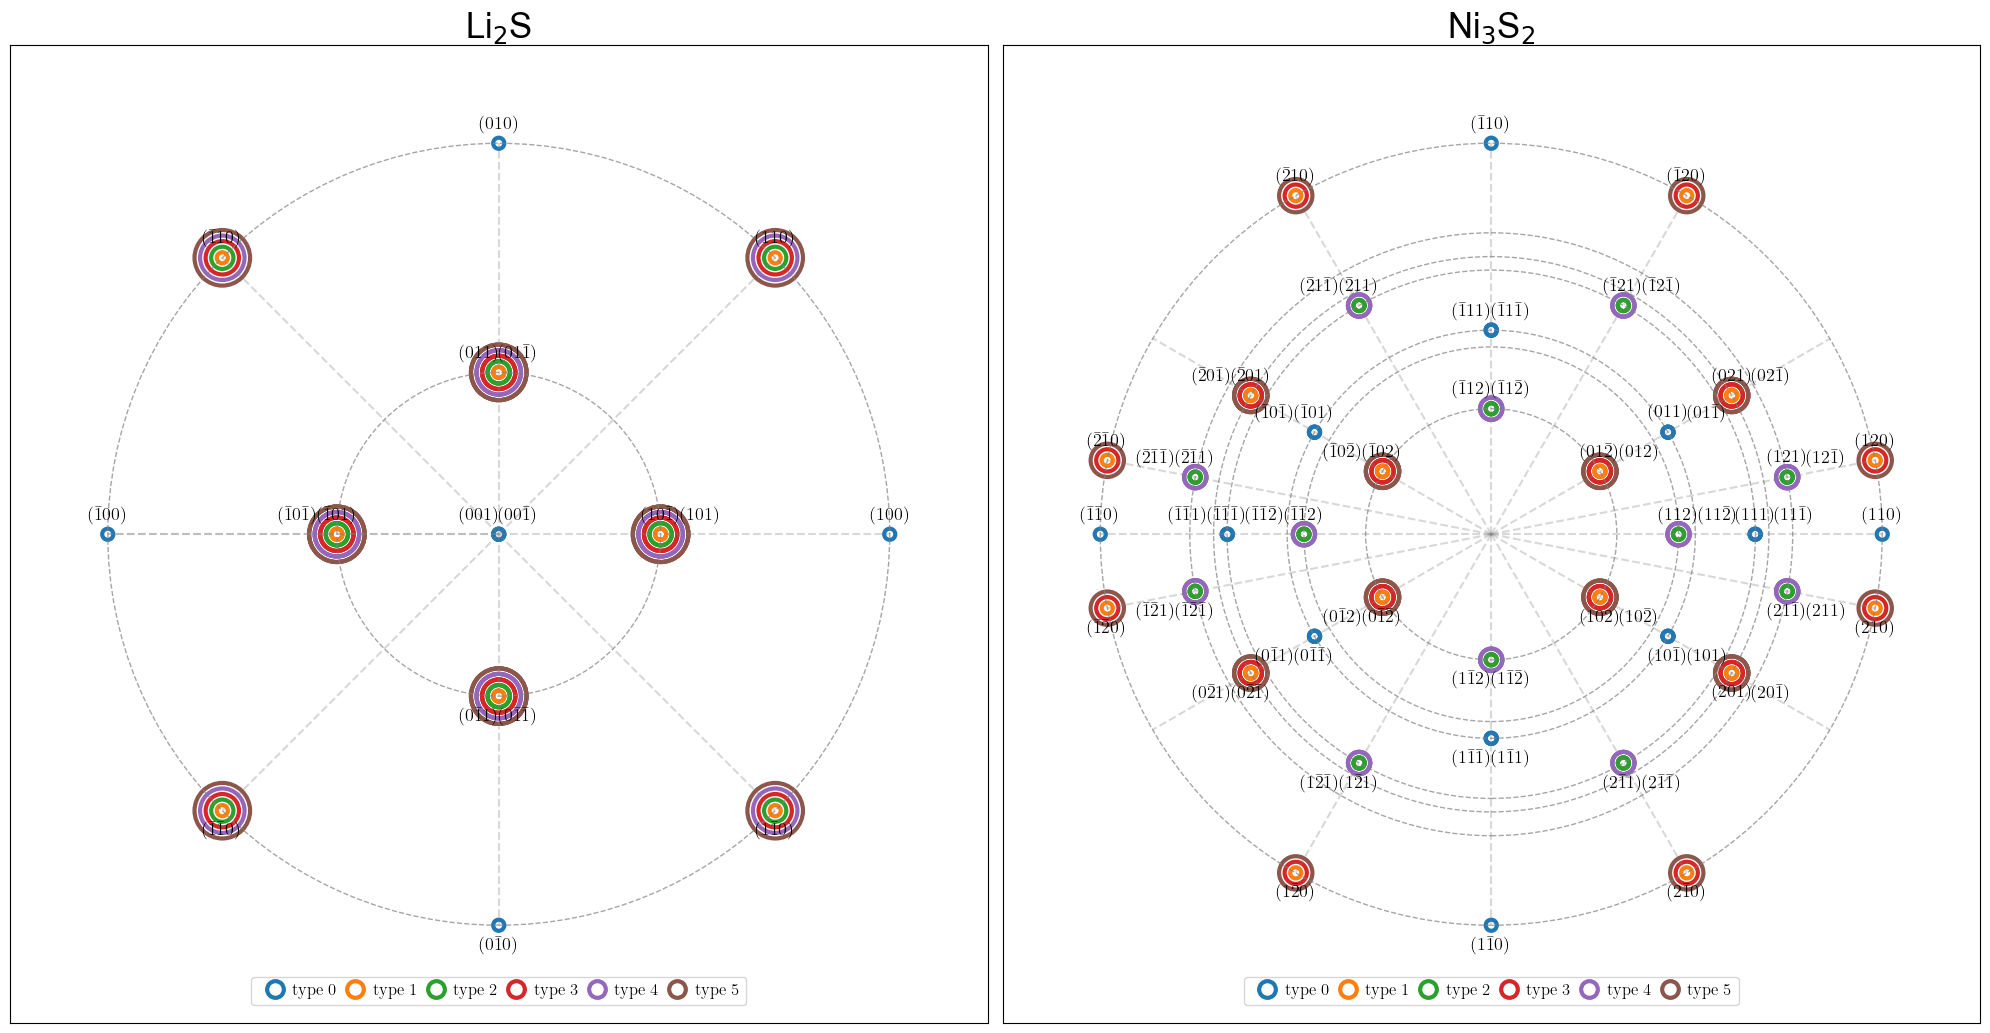

In [6]:
iw.ems.plot_matching_data(['Li$_2$S', 'Ni$_3$S$_2$'],'Ni3S2_Li2S_more.jpg', show_millers = True, show_legend = True)

# Define interface structural parameters 

In [7]:
#These are defualt settings
iw.parse_interface_structure_params(termination_ftol = 0.01, c_periodic = False, \
                                    vacuum_over_film = 8, film_thickness = 10, \
                                    substrate_thickness = 10, shift_to_bottom = True)
#This will also screen out all the identical terminations

symmetry checking progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

# Generate interface with random sampled rigid body translation

In [8]:
its, xyzs, xyz_cs = iw.random_sampling_specified_interface(match_id = 0, term_id = 0, n_taget = 20, 
                                                           n_max = 100, sampling_min_displace = 1, discut = 0.8)

match_id (int): unique match id  
term_id (int): unique termination id  
n_taget (int): target number of sampling  
n_max (int): max number of trials  
sampling_min_displace (float): sampled rigid body translation position are not allowed to be closer than this (angstrom)  
discut (float): the atoms are not allowed to be closer than this (angstrom)  

In [9]:
#generate poscar files
import os, shutil, json
try:
    shutil.rmtree('cnid_random_sample')
except:
    print('folder not exist')
os.mkdir('cnid_random_sample')
for i in range(len(its)):
    Structure.from_dict(json.loads(its[i])).to_file(f'cnid_random_sample/{i}_POSCAR')

# Baysian Optimization by MLIP for Rigid Body Translation (RBT)

In [10]:
#define structure optimization conditions (optional). If not called, the non-optimized energy and structure will be used
iw.parse_optimization_params(do = True, fix_shell = True, fix_in_layers = True, fix_thickness = 1)

do: whether to apply structure optimization for the sampled structure with minimum non-optimized energy  
fix_shell: whether to fix the bottom of the substrate  
fix_in_layers: whether to specify number of layers to set fix thickness  
fix_thickness: thickness to fix (in angstrom or in layers)  

In [11]:
#For presentation, small n_calls is used there; please increase this number for better optimization results
iw.global_minimization(n_calls = 10, z_range = (0.5, 3), calc = 'mace', discut = 0.8, user_settings={'timeout':600})

default settings
{'model': 'medium', 'device': 'cpu'}
crpi-aqvrppj8ebnguc34.cn-shenzhen.personal.cr.aliyuncs.com/jinlhr542/mace:0.0.1 container initializing...
Flask service is ready.
Performing initialization calculation ...
Completed !


matches:   0%|          | 0/6 [00:00<?, ?it/s]

unique terminations:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

unique terminations:   0%|          | 0/5 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

n_calls: number of trials per lattice match per termination  
z_range: range of interface gap by angstroms
calc: mlip calculator ('mace', 'orb-models', 'sevenn', 'chgnet', 'grace-2l')  
discut: minimum allowed atomic distance by angstroms (too close atom distance might result in unreasonably low energy)

In [ ]:
iw.global_optimized_data

Definition of the interface energy $E_{it}$ and binding energy $E_{bd}$ see:  
doi:10.26434/chemrxiv-2024-hwthh

# Get the interface with lowest predicted energy by MLIP

In [ ]:
best_key = (iw.global_optimized_data['$i_m$'].to_numpy()[0], iw.global_optimized_data['$i_t$'].to_numpy()[0])
best_key

In [12]:
iw.opt_results[best_key]['relaxed_best_interface']['structure'].to_file('POSCAR')

NameError: name 'best_key' is not defined

iw.chg_opt_results is a dict with keys being (unique match index, unique termination index) and this dict has saved all the optimization information.

In [ ]:
iw.opt_results.keys()

sampled_interfaces, xyzs_ognl(sampled rbt input), xyzs_cart(sampled rbt in cartesian) are ranked by predicted energy;
and therefore the first items are for the lowest interface structure for this (unique match index, unique termination index)